## Geeksforgeeks Data analysis

Initialization for data, need to scrape it from given link and convert it to frame before answering question.

Importing liberaries.

In [21]:
from bs4 import BeautifulSoup
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from selenium import webdriver
import calendar
import spacy

Downloading `spacy` nlp module for processing further.

In [23]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB 1.3 MB/s eta 0:00:10
     ---------------------------------------- 0.1/12.8 MB 1.1 MB/s eta 0:00:12
     --------------------------------------- 0.1/12.8 MB 871.5 kB/s eta 0:00:15
     --------------------------------------- 0.1/12.8 MB 871.5 kB/s eta 0:00:15
     --------------------------------------- 0.1/12.8 MB 871.5 kB/s eta 0:00:15
     --------------------------------------- 0.1/12.8 MB 385.0 kB/s eta 0:00:33
     --------------------------------------- 0.1/12.8 MB 448.2 kB/s eta 0:00:29
      -------------------------------------- 0.2/12.8 MB 535.8 kB/s eta 0:00:24
      -------------------------------------- 0.2/12.8 MB 554.9 kB/s eta 0:00:23
      -------------------------------------- 0.3/12.8 MB 582.4 kB/s eta 0:00:22
      -------------------------------------- 0.3/12.8 MB 582.4 kB/s eta 0:00:22
      -------------------------------------- 0.3/1


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: C:\Users\pverma\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Scraping from link.

In [3]:
YOUTUBE_URL = 'https://www.youtube.com' 
SOURCE_URL = 'https://www.youtube.com/@GeeksforGeeksVideos/videos?view=0&sort=p&flow=grid'
TIME_LIMIT = '7 months' # task for 6 months and stopage on 7th one

driver = webdriver.Edge()
driver.get(SOURCE_URL)
stop = False
while not stop:
    content = driver.page_source.encode('utf-8').strip()
    soup = BeautifulSoup(content, 'lxml')
    title = soup.findAll('yt-formatted-string', id='video-title')
    metadata = soup.findAll('span', class_='inline-metadata-item style-scope ytd-video-meta-block')
    video_url = soup.findAll('a', id='video-title-link')
    duration = soup.findAll('span', class_ = "style-scope ytd-thumbnail-overlay-time-status-renderer")
    # note that this doesnot ensure that it will have only 6 months data
    stop = any([TIME_LIMIT in meta.text for meta in metadata])
    driver.execute_script("window.scrollBy(0,1000)")


Note that here, selenium is used for making things work, its because youtube have a lazy loading concept in which it loads the videos on scrolling events from the browser.

To handle this we need to ave browser doing scrolling events, which is not possible to achive by static pages (i.e simple get request).

Please make sure that the edge browser is installed when you execute this code.

In [4]:
data = {}
data['length of videos'] = [str(duration[dur].text).strip() for dur in range(0, len(duration), 2)]
data['titles'] = [tile.text for tile in title]
data['videos link'] = [url['href'] for url in video_url]
data['views'] = [str(metadata[ind].text).strip() for ind in range(0, len(metadata), 2)]
data['time uploaded'] = [str(metadata[ind].text).strip() for ind in range(1, len(metadata), 2)]
data = pd.DataFrame(data)
data.head()

,length of videos,titles,videos link,views,time uploaded
0,3:47,All Your Queries Answered | DSA to Development...,/watch?v=kHBzDvj3D2U,723 views,1 day ago
1,9:53,10 TIPS and TRICKS to Crack Internships and Pl...,/watch?v=2QDMIZGeIC4,685 views,6 days ago
2,0:56,Complete School Guide for CBSE | Free Resource...,/watch?v=1ECMlxC6jbs,513 views,7 days ago
3,0:46,Master System Design | GeeksforGeeks,/watch?v=vjWLZYeqiN8,7.3K views,11 days ago
4,45:44,"Unraveling the Geek-a-thon: The What, How, and...",/watch?v=6e0v_NhsFMQ,440 views,12 days ago


### 1) Number of videos in the past 6 months from the start date. Must mention the dates in the solution.

In the given data we have videos with `x days ago` format. Changing those to dates.

In [5]:
def map_time(x):
    if x['units'] in ['hour', 'hours']:
        return (dt.datetime.now() - dt.timedelta(hours=x['ago number'])).date()
    if x['units'] in ['day', 'days']:
        return (dt.datetime.now() - dt.timedelta(days=x['ago number'])).date()
    if x['units'] in ['month', 'months']:
        return (dt.datetime.now() - dt.timedelta(days=x['ago number'] * 
                    calendar.monthrange(dt.datetime.now().year, dt.datetime.now().month)[1])).date()
data['ago number'] = data['time uploaded'].str.split(expand=True)[0].astype(int)
data['units'] = data['time uploaded'].str.split(expand=True)[1].astype(str)
data = data[(data['units'] != 'months') | (data['ago number'] <= 6)]
data['time uploaded date'] = data.apply(map_time, axis=1)
data.drop(columns=['ago number', 'units'], inplace=True)
data.head()

,length of videos,titles,videos link,views,time uploaded,time uploaded date
0,3:47,All Your Queries Answered | DSA to Development...,/watch?v=kHBzDvj3D2U,723 views,1 day ago,2023-08-07
1,9:53,10 TIPS and TRICKS to Crack Internships and Pl...,/watch?v=2QDMIZGeIC4,685 views,6 days ago,2023-08-02
2,0:56,Complete School Guide for CBSE | Free Resource...,/watch?v=1ECMlxC6jbs,513 views,7 days ago,2023-08-01
3,0:46,Master System Design | GeeksforGeeks,/watch?v=vjWLZYeqiN8,7.3K views,11 days ago,2023-07-28
4,45:44,"Unraveling the Geek-a-thon: The What, How, and...",/watch?v=6e0v_NhsFMQ,440 views,12 days ago,2023-07-27


### 2. Create a pandas data frame with columns name as videos title, views, Length of videos, and videos link

Converting `views` to something processable

In [6]:
def map_mul_factor(x):
    numeric = x['views'].split()[0]
    if 'K' in numeric:
        return int(float(numeric.split('K')[0]) * 1000)
    else:
        return int(numeric)

data['views'] = data.apply(map_mul_factor, axis=1)
data.head()

,length of videos,titles,videos link,views,time uploaded,time uploaded date
0,3:47,All Your Queries Answered | DSA to Development...,/watch?v=kHBzDvj3D2U,723,1 day ago,2023-08-07
1,9:53,10 TIPS and TRICKS to Crack Internships and Pl...,/watch?v=2QDMIZGeIC4,685,6 days ago,2023-08-02
2,0:56,Complete School Guide for CBSE | Free Resource...,/watch?v=1ECMlxC6jbs,513,7 days ago,2023-08-01
3,0:46,Master System Design | GeeksforGeeks,/watch?v=vjWLZYeqiN8,7300,11 days ago,2023-07-28
4,45:44,"Unraveling the Geek-a-thon: The What, How, and...",/watch?v=6e0v_NhsFMQ,440,12 days ago,2023-07-27


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70 entries, 0 to 69
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   length of videos    70 non-null     object
 1   titles              70 non-null     object
 2   videos link         70 non-null     object
 3   views               70 non-null     int64 
 4   time uploaded       70 non-null     object
 5   time uploaded date  67 non-null     object
dtypes: int64(1), object(5)
memory usage: 3.8+ KB


### 3) Name the most viewed topics in the past 6 months.

In [20]:
data.groupby('titles')['views'].max().sort_values().tail(1)

titles
GeeksforGeeks Classroom Program | Now in Noida and Gurugram!    112000
Name: views, dtype: int64

For taking the topic in concideration lets extract the keywords from description. This will be done accross the dataset and then we will find topics.

In [26]:
punctuation = ['|', '.', '?', '!', 'geeksforgeeks', 'gfg']
def get_keywords(x):
    text = x['titles']
    result = []
    tag = ['PROPN', 'ADJ', 'NOUN']
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text.lower())
    for token in doc:
        if(token.text in nlp.Defaults.stop_words or token.text in punctuation):
            continue
        if(token.pos_ in tag):
            result.append(token.text)
    
    return ', '.join(set([i for i in result]))

data['keywords'] = data.apply(get_keywords, axis=1)
data.head()

,length of videos,titles,videos link,views,time uploaded,time uploaded date,keywords
0,3:47,All Your Queries Answered | DSA to Development...,/watch?v=kHBzDvj3D2U,723,1 day ago,2023-08-07,"queries, development, dsa, program"
1,9:53,10 TIPS and TRICKS to Crack Internships and Pl...,/watch?v=2QDMIZGeIC4,685,6 days ago,2023-08-02,"tips, internships, tricks, placements"
2,0:56,Complete School Guide for CBSE | Free Resource...,/watch?v=1ECMlxC6jbs,513,7 days ago,2023-08-01,"guide, complete, free, school, resources, cbse..."
3,0:46,Master System Design | GeeksforGeeks,/watch?v=vjWLZYeqiN8,7300,11 days ago,2023-07-28,"system, design, master"
4,45:44,"Unraveling the Geek-a-thon: The What, How, and...",/watch?v=6e0v_NhsFMQ,440,12 days ago,2023-07-27,"geek, thon"


In [28]:
data.groupby(['titles', 'keywords'])['views'].max().sort_values().tail(1)

titles                                                        keywords                           
GeeksforGeeks Classroom Program | Now in Noida and Gurugram!  gurugram, program, noida, classroom    112000
Name: views, dtype: int64

### 4) Name the topics with the highest video length.

In [40]:
def get_sec(x):
    div_time = x['length of videos'].split(':')
    if len(div_time) == 1:
        return int(div_time[0])
    elif len(div_time) == 2:
        return int(div_time[0])*60 + int(div_time[1])
    return int(div_time[2])*3600 + int(div_time[1])*60 + int(div_time[0])

data['time in secs'] = data.apply(get_sec, axis=1)
data

,length of videos,titles,videos link,views,time uploaded,time uploaded date,keywords,time_in_secs,time in secs
0,3:47,All Your Queries Answered | DSA to Development...,/watch?v=kHBzDvj3D2U,723,1 day ago,2023-08-07,"queries, development, dsa, program",227,227
1,9:53,10 TIPS and TRICKS to Crack Internships and Pl...,/watch?v=2QDMIZGeIC4,685,6 days ago,2023-08-02,"tips, internships, tricks, placements",593,593
2,0:56,Complete School Guide for CBSE | Free Resource...,/watch?v=1ECMlxC6jbs,513,7 days ago,2023-08-01,"guide, complete, free, school, resources, cbse...",56,56
3,0:46,Master System Design | GeeksforGeeks,/watch?v=vjWLZYeqiN8,7300,11 days ago,2023-07-28,"system, design, master",46,46
4,45:44,"Unraveling the Geek-a-thon: The What, How, and...",/watch?v=6e0v_NhsFMQ,440,12 days ago,2023-07-27,"geek, thon",2744,2744
...,...,...,...,...,...,...,...,...,...
65,2:41,Optimal Way to Get Started with DSA | Geeksfor...,/watch?v=-WLD1oY2dB4,7100,6 months ago,2023-02-03,"way, optimal, dsa",161,161
66,1:02,Mistakes to Avoid in Your Next Job Interview |...,/watch?v=1uO3E57gPpE,1500,6 months ago,2023-02-03,"mistakes, job, interview",62,62
67,3:58,Master These Coding Practices For Your Placeme...,/watch?v=v_mlqwjlv00,5400,6 months ago,2023-02-03,"placement, preparation, practices",238,238
68,0:46,Correct Your Mistakes in 1 minute | Data Scien...,/watch?v=vNiiuh__7u0,1200,6 months ago,2023-02-03,"mistakes, science, data, minute",46,46


In [36]:
data.groupby(['titles', 'keywords'])['time in secs'].max().sort_values().tail(1)

titles                                                   keywords                               
Data Analysis Masterclass | Geek-A-Thon | GeeksforGeeks  geek, thon, data, analysis, masterclass    77341
Name: time in secs, dtype: int64

### 5) Make a comparison between the number of views and video length using a Graph.

Lets visualize the dataset for comparision betwen views and video length using matplotlib `linegraph`.

Text(0, 0.5, 'Time[s]')

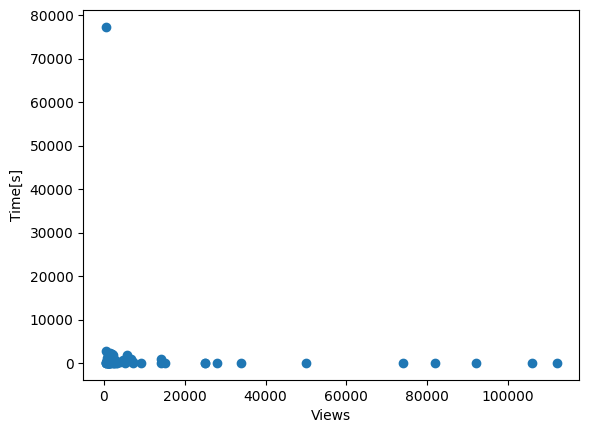

In [42]:
plt.scatter(
    data['views'],
    data['time in secs']
)
plt.xlabel('Views')
plt.ylabel('Time[s]')

Here we can see we donot have much coordination, lets tr removing an outlier with respect to time i.e `77341`

Text(0, 0.5, 'Time[s]')

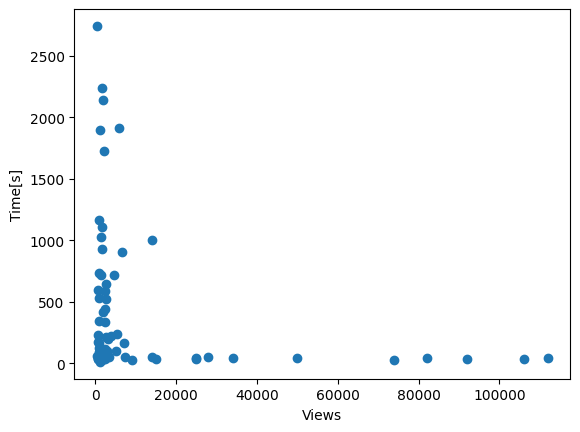

In [43]:
plt.scatter(
    data[data['time in secs'] != 77341]['views'],
    data[data['time in secs'] != 77341]['time in secs']
)
plt.xlabel('Views')
plt.ylabel('Time[s]')

We have an expected relation here where shorter the video, more are the views for that. 